<a href="https://colab.research.google.com/github/AgaZgo/peft_fine_tuning/blob/main/flan_t5_fine_tune_lora_wandb_ray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Fine tune Flan-T5 model with Low-Rank Adaptation on dialog summarization task**
## Objective
The goal of this notebook is to provide a template for training LLMs using state-of-the-art techniques. We go through the process of fine tuning Google's Flan-T5 large language model on dialog summarization task using Low-Rank Adaptation. We also perform hyperparameter tuning with Ray Tune library. Our experiments are tracked by Weights & Biases.

We use the 'xl' version of the model (3B parameters). As our training dataset we use 'dialogsum' dataset provided by HuggingFace.

## Hardware remarks
To run this notebook with 'xl' size of the Flan-T5 we use A100 GPU (40GB). At the time of creating this notebook A100 was fairly easily accessible on Google Colab Pro, despite general shortage of high end GPUs accelarators. Changing model size to 'large' allows training on T4 GPU using free Google Colab account, although execution time constraints may not allow to perform many hyperparameter search trials in one go.

Since we want to keep the costs low, we don't perform extensive training. We will limit number number of training and number of hyperparameter tuning trials



## 1. Installing required libraries

We will build this project tools from HuggingFace libraries:
- transformers - basic HF tool for model loading and training
- datasets - loading and prepocesisng dataset
- evaluate - provides 'rouge' metrics
- rouge_score - required by evaluate
- peft - provides tools for Parameter Efficient Fine Tuning
- loralib - required by peft
- accelerate - to train in bf16 ????

Additional tools:
- wandb - for experiment tracking
- ray - for hyperparameter tuning
- hyperopt - used by Ray for TPE hyperparameter search algorithm


In [ ]:
!pip install \
    transformers==4.31.0 \
    datasets==2.14.4 \
    evaluate==0.4.0 \
    rouge_score==0.1.2 \
    peft==0.4.0 \
    loralib==0.1.1 \
    accelerate==0.21.0 \
    wandb==0.15.8 \
    ray[air]==2.6.1 \
    hyperopt==0.2.7 -q

## 2. Imports and environment variables
We set environment variables used during training for logging to Weights & Biases

In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, Seq2SeqTrainingArguments, Seq2SeqTrainer, EarlyStoppingCallback
from datasets import load_dataset
from peft import LoraConfig, get_peft_model

from ray import tune
from ray.tune.search.hyperopt import HyperOptSearch
from ray.air import RunConfig, session

from datetime import datetime

import numpy as np
import evaluate
import nltk
import torch
import wandb
import os

os.environ['WANDB_LOG_MODEL']='end' #saves only last model to W&B; when used with 'load_best_model_at_end=True' in Trainer, saves best model as an artifact
os.environ['WANDB_PROJECT']='flan-t5-peft'
os.environ["WANDB_SILENT"] = "true"  #disable printing out wandb logs to console

nltk.download('punkt', quiet=True)

## 3. Weights & Biases login

To enable tracking our experiment in W&B, first we need an account (free) and then copy our API key from https://wandb.ai/settings (scroll down to 'Danger Zone'). Paste your API key when prompted after running the cell below.

In [ ]:
wandb.login()

## 4. Choose your basic settings

In [ ]:
DATASET_NAME = 'knkarthick/dialogsum'  # Hugging Face name of the dataset
GPU = 'a100'  # does not set GPU, this is to provide information which GPU is manually set by user
MODEL_SIZE = 'xl'  # 'base', 'large' or 'xl'

# below are maximal values of batch sizes that given GPU was capable to train with
max_batchsize = {
    't4': {'base': 4,'large': 1},
    'a100': {'base': 8,'large': 4,'xl': 2}  # to train 'xl' with batch_size==2 on a100(40GB) must use bfloat16
}  # powers of 2 recommended

# arguments to be passed to train_model()
train_args = {
    'es_patience':3,  #early stopping patience
    'best_model_metric': 'eval_rougeLsum', #main model performance metric
    'per_device_train_batch_size': max_batchsize[GPU][MODEL_SIZE],
    'total_train_examples': 8192,
    'model_size': MODEL_SIZE
}

#arguments to be passed to tune.Tuner()
n_init_points = 10  #number of random hyperparameter settings to run before applying TPE in hyperparameter choices
time_budget_seconds = 60 * 60 * 15  #time limit for hyperparameter tuning
num_trials = 25  #number of runs performed by hyperparameter search algorithm

## 5. Prepare data
We will transformed our dialogs into prompts starting with instruction "Summarize the following dialogue:\n\n", followed by dialog itself and ending with "\n\nSummary:". We will then tokenize out dataset.

In [ ]:
def get_tokenized_dataset(dataset_name, model_size):
    dataset = load_dataset(dataset_name)
    model_name = f"google/flan-t5-{model_size}"
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    def preprocess_data(examples):
        start_prompt = "Summarize the following dialogue:\n\n"
        end_prompt = "\n\nSummary:"
        prompts = [start_prompt + dialogue + end_prompt for dialogue in examples['dialogue']]
        examples['input_ids'] = tokenizer(prompts, padding='max_length', truncation=True)['input_ids']
        examples['label'] = tokenizer(examples['summary'], padding='max_length', truncation=True)['input_ids']
        examples['label'] = [
            [-100 if token==tokenizer.pad_token_id else token for token in label] for label in examples['label']
        ]
        return examples

    dataset_tokenized = dataset.map(preprocess_data, batched=True)
    dataset_tokenized.set_format('torch')

    return dataset_tokenized

train_args['dataset'] = get_tokenized_dataset(DATASET_NAME, MODEL_SIZE)

## 6. Define training function
This is the most complex step as it incorporates all all the tools and techniques involved in this project.  

### 'Rouge' metrics
Rouge is a family of metrics which is one of the standard methods to measure models' performance on summarization task. My choice for performance assessment is 'rougeLsum'.

### Low Rank Adaptations
The make training of LLM possible/viable/feasible we use one of the PEFT methods called Low Rank Adaptation (LoRA). The core idea of this method is to freeze pre-trained model weights and add new trainable matrices to some of the models layers. Each of these new matrices should be a product of two low rank matrices. This allow to significantly reduce the number of trainable parameters,while preserving complexity of the model. During model fine tuning original weights are frozen and only new weights are updated.  

### Quantization
We will use 'bfloat16' data type instead of original float32. This will allow us to fit larger batches into GPU. (And hopefully perform inference on T4)

### Hugging Face training API
HF offers two classes of trainers: Trainer and Seq2SeqTrainer. The latter works with sequence-to-sequence' models, such as Flan-T5. Main difference between these trainer is that the latter offers 'predict_with_generate' method which we need for computing rouge score during evaluation loop.


In [ ]:
def train_model(config, params):

    #start wandb instance with the same run name as ray trial name
    run_name = session.get_trial_name()
    wandb.init(name=run_name, config=config)

    #get Flan-T5 model from HF Hub
    model_name = f"google/flan-t5-{params['model_size']}"
    base_model = AutoModelForSeq2SeqLM.from_pretrained(model_name, device_map='auto', torch_dtype=torch.bfloat16)  # bf16 only for Ampere GPU
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    #load 'rouge' metric for model evaluation'
    rouge = evaluate.load('rouge')

    #define 'compute_metrics' function to be evaluated during evaluation loop in HF trainer
    def compute_metrics(eval_preds):
        preds, labels = eval_preds

        labels = np.where(labels!=-100, labels, tokenizer.pad_token_id)
        decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
        decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

        # sentences seperated with '\n' as required by rougeLsum
        decoded_preds = ["\n".join(nltk.sent_tokenize(preds.strip())) for preds in decoded_preds]
        decoded_labels = ["\n".join(nltk.sent_tokenize(labels.strip())) for labels in decoded_labels]

        results =  rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

        return results

    early_stopping = EarlyStoppingCallback(early_stopping_patience=params['es_patience'])

    output_dir = f"./lora_training/{run_name}"

    lora_params = {
        'r': config['lora_r'],
        'lora_alpha': config['lora_alpha'],
        'target_modules': ['q', 'v'],
        'lora_dropout': 0.05,
        'bias': 'none',
        'task_type': "SEQ_2_SEQ_LM"
    }

    lora_config = LoraConfig(**lora_params)

    lora_model = get_peft_model(
        base_model,
        lora_config
    )

    lora_training_args = Seq2SeqTrainingArguments(
        output_dir=output_dir,
        learning_rate=config['learning_rate'],
        per_device_train_batch_size=min(params['per_device_train_batch_size'], config['effective_batch_size']),
        gradient_accumulation_steps=max(1, config['effective_batch_size']//params['per_device_train_batch_size']),
        max_steps=params['total_train_examples']//config['effective_batch_size'],
        logging_steps=1024//config['effective_batch_size'],  #logging every 1024 examples
        evaluation_strategy='steps',
        save_steps=1024//config['effective_batch_size'],  #saving every 1024 examples
        logging_dir=output_dir+"/logs",
        predict_with_generate=True,  #we need to generate outputs to compute 'rouge' metrics
        load_best_model_at_end=True,
        metric_for_best_model=params['best_model_metric'],
        disable_tqdm=True,
        bf16=True,
        report_to='wandb',
        run_name=run_name
    )

    lora_trainer = Seq2SeqTrainer(
        model=lora_model,
        args=lora_training_args,
        train_dataset=params['dataset']['train'],
        eval_dataset=params['dataset']['validation'],
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        callbacks=[early_stopping]
    )

    lora_trainer.train()
    #get value of the chosen metric for best model (checkpoint)
    result = {params['best_model_metric']: lora_trainer.state.best_metric}
    wandb.finish()
    return result

## Tune hyperparameters with Ray Tune



In [ ]:
'''
We use Ray Tune wrappers to:
- pass additional parameters: train_args. Hyperparameters which we will tune will be passed by Ray in 'config'
- assign resources which to be used by Tuner() to run the function
'''
train_model = tune.with_resources(
    tune.with_parameters(
        train_model,
        params = train_args
    ),
    {"gpu": 1, 'cpu':12}
)


#Define hyperparameter space.
search_space = {
    'lora_r': tune.randint(8,25),
    'lora_alpha': tune.quniform(1,25,0.5),
    'effective_batch_size': tune.choice([8,16,32]),  # powers of 2 recommended
    'learning_rate': tune.qloguniform(1e-4,1e-2,5e-5)
}

'''
Define tuning config.
Hyperparameter search algorithm provided by hyperopt is Tree of Parzen Estimators (TPE)
'''
tune_config = tune.TuneConfig(
    num_samples=num_trials,
    search_alg=HyperOptSearch(metric='eval_rougeLsum', mode='max', n_initial_points=n_init_points),
    time_budget_s=time_budget_seconds,
    trial_name_creator = lambda trial: f"lora_{trial.trial_id}_{datetime.now().strftime('%m%d%H%M')}"
)

run_config = RunConfig(
    storage_path="./ray"
)

#Initialize hyperparameter tuner
tuner = tune.Tuner(
    train_model,
    param_space=search_space,
    tune_config=tune_config,
    run_config=run_config
)

#Run hyperparameter search
tuner.fit()

## See results in Weights & Biases

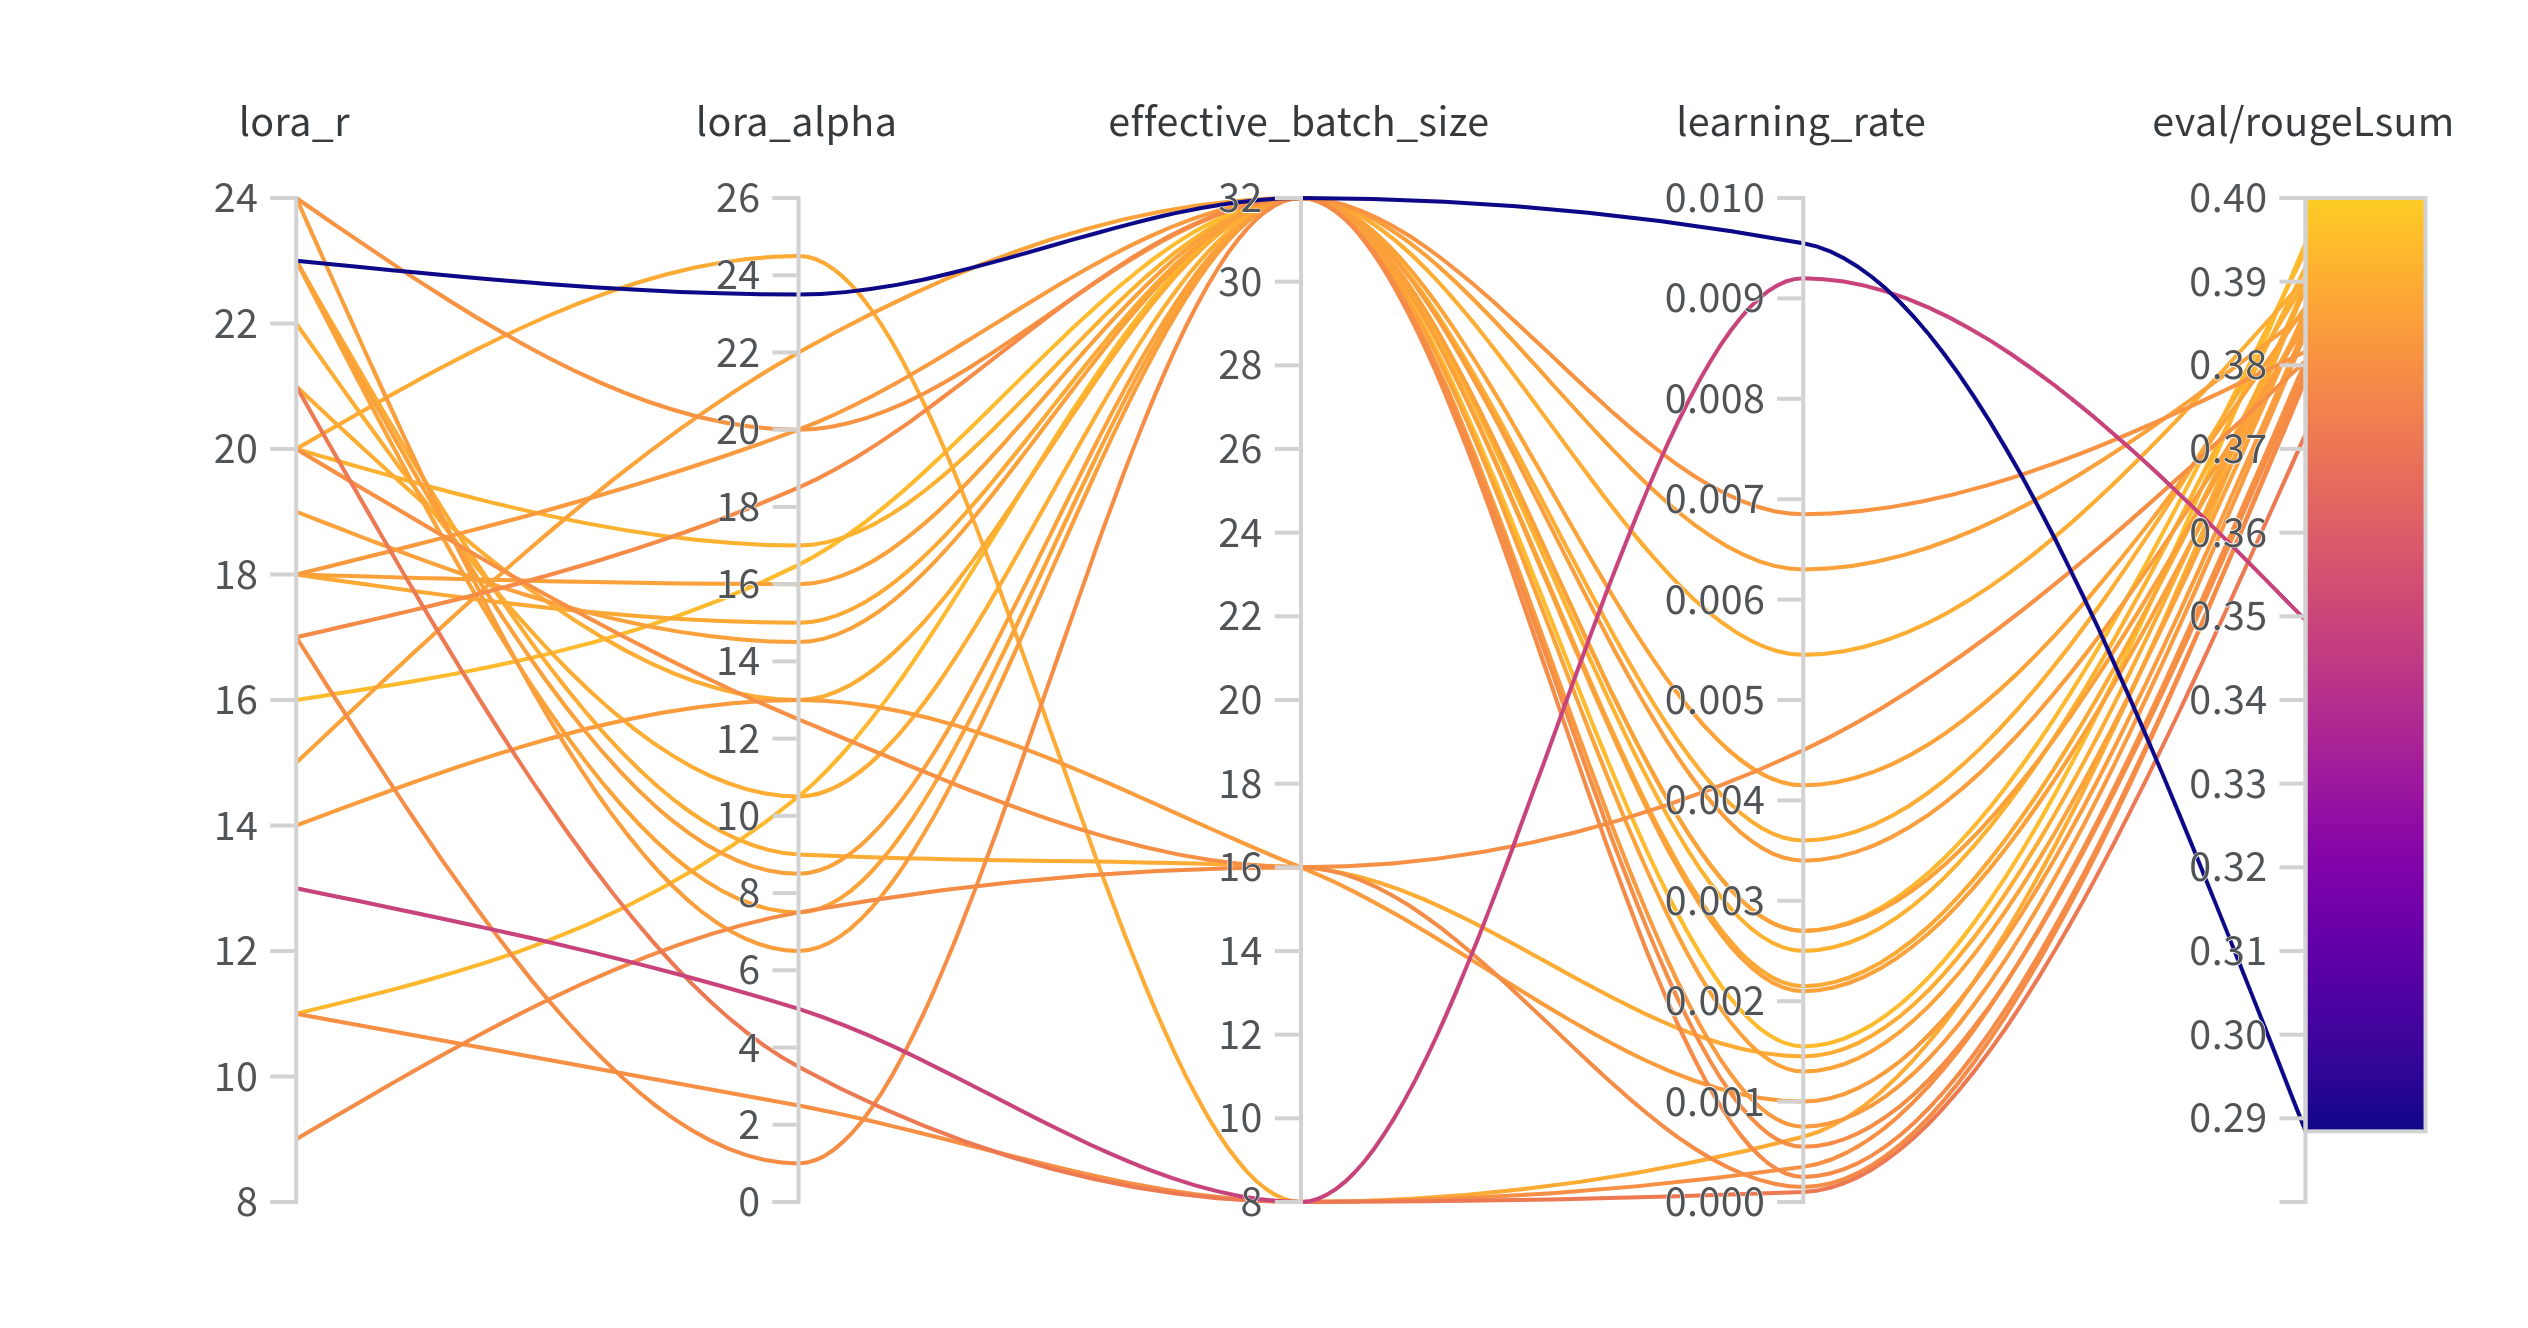

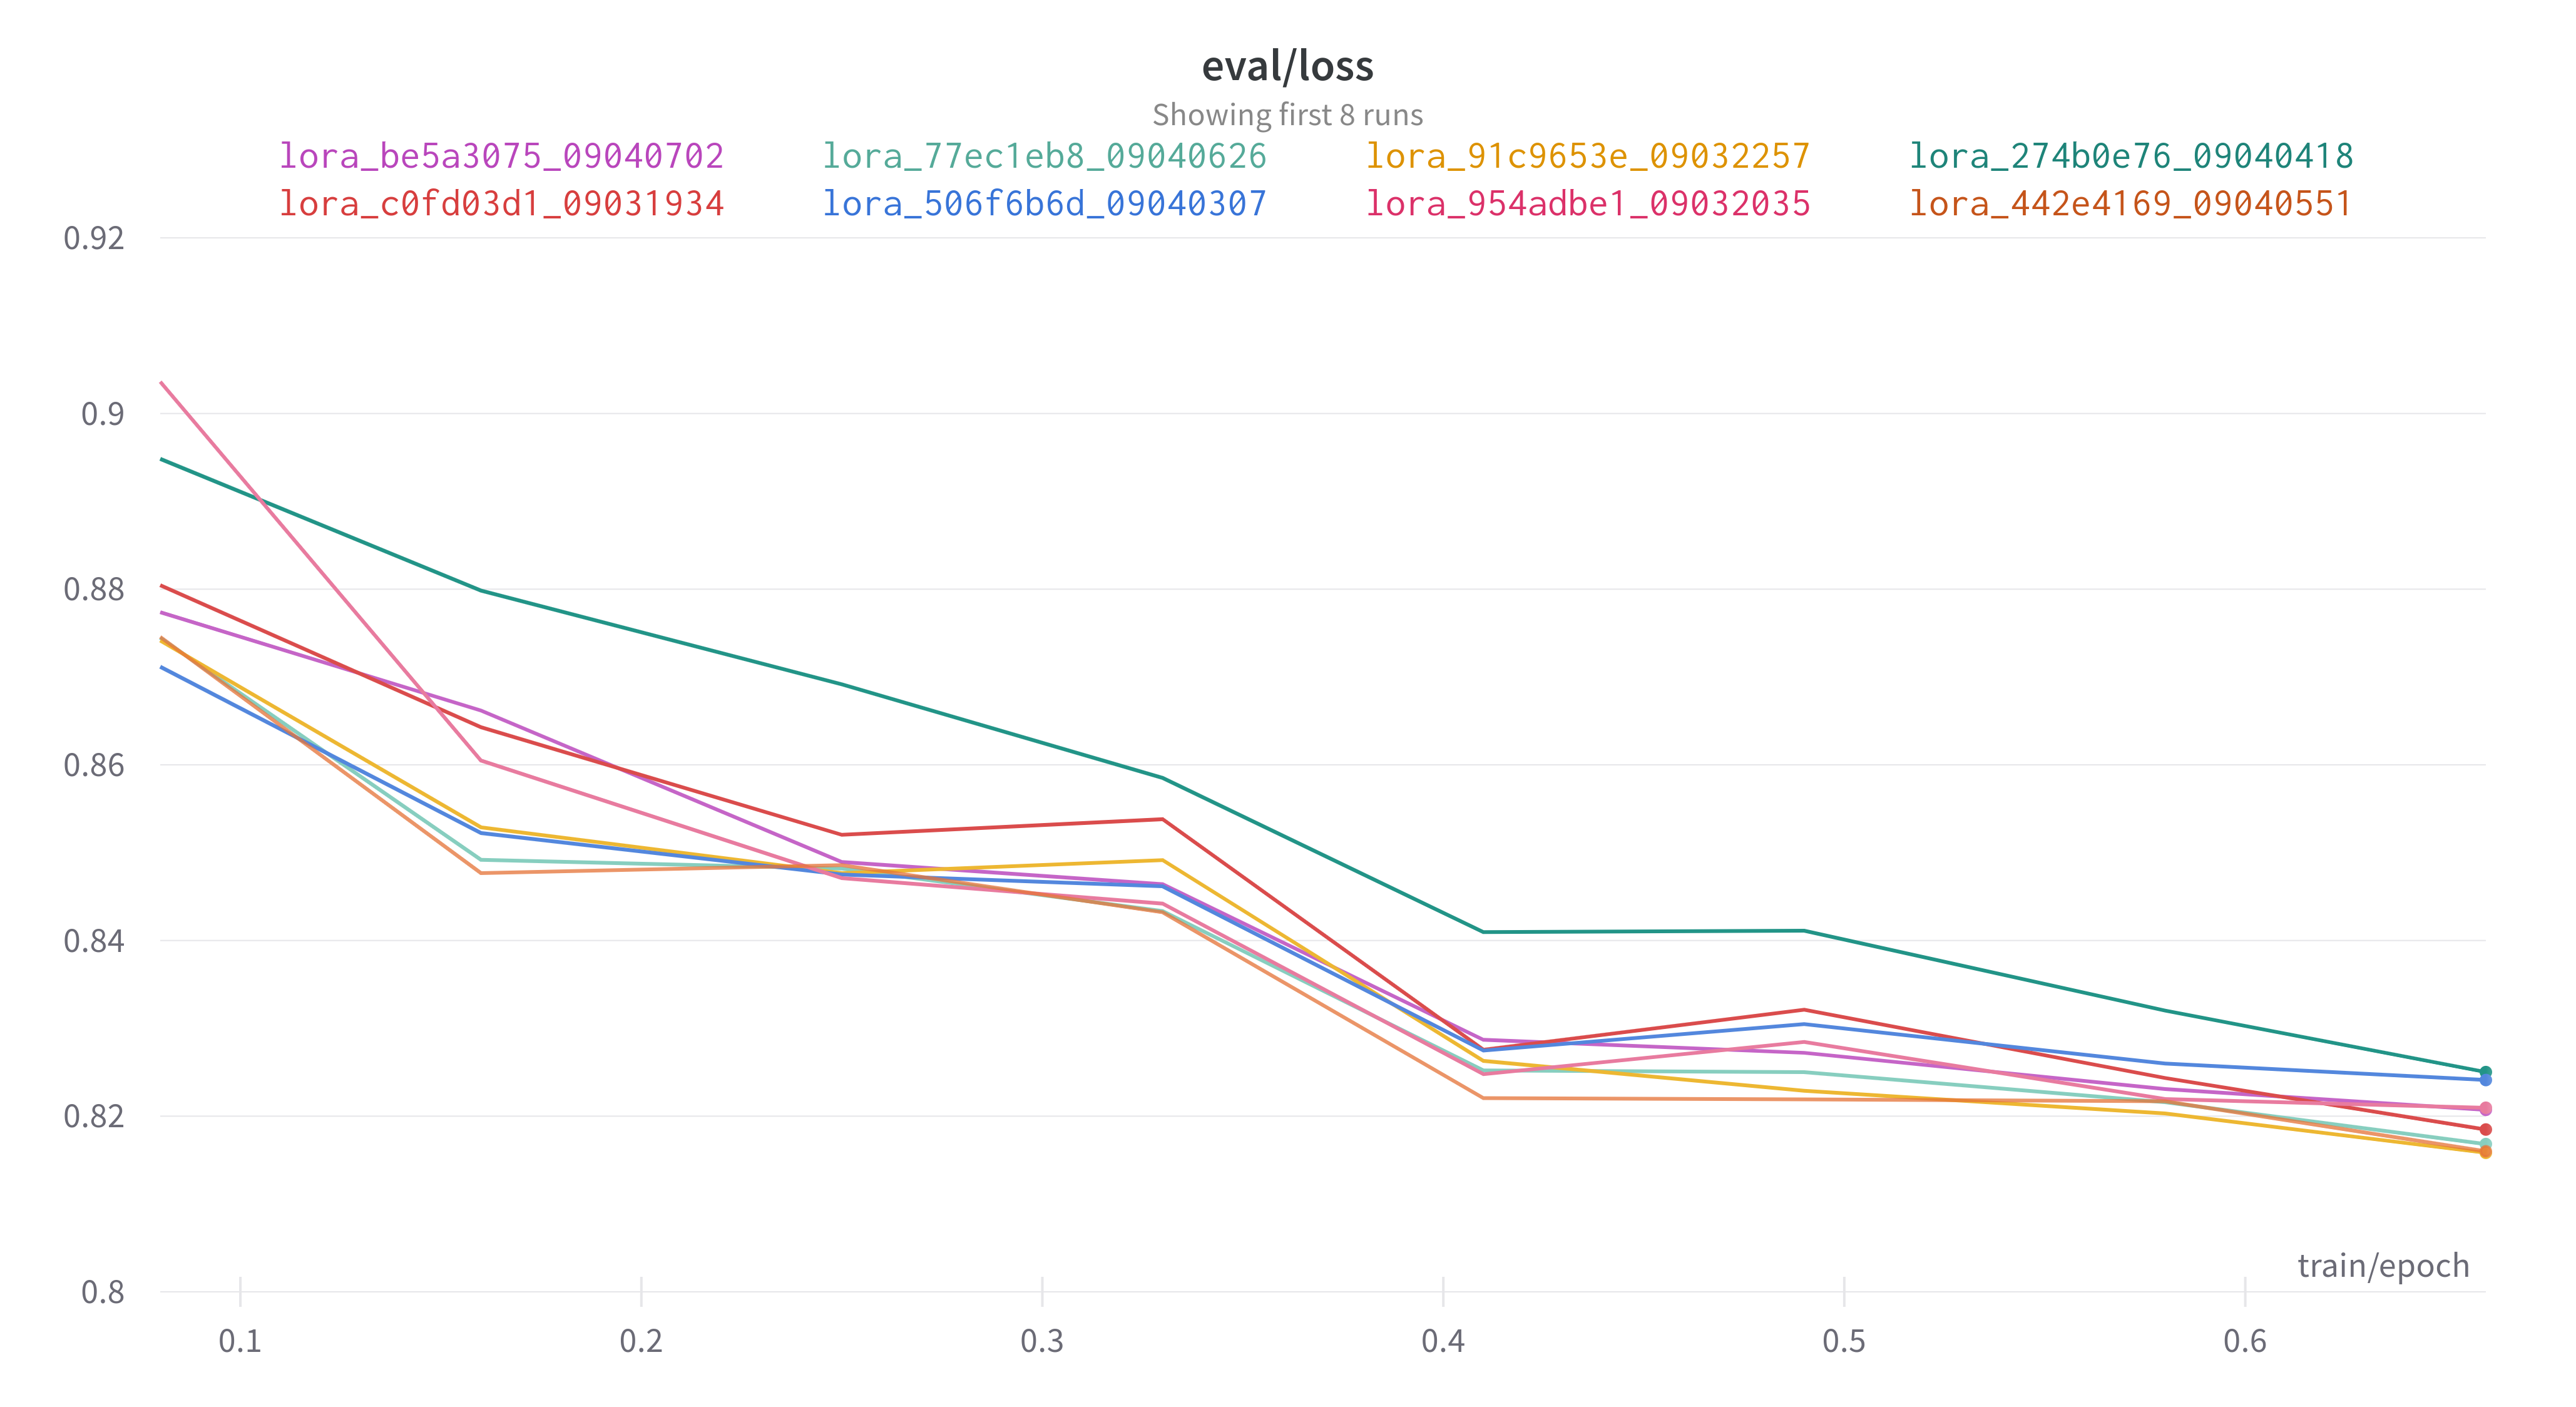

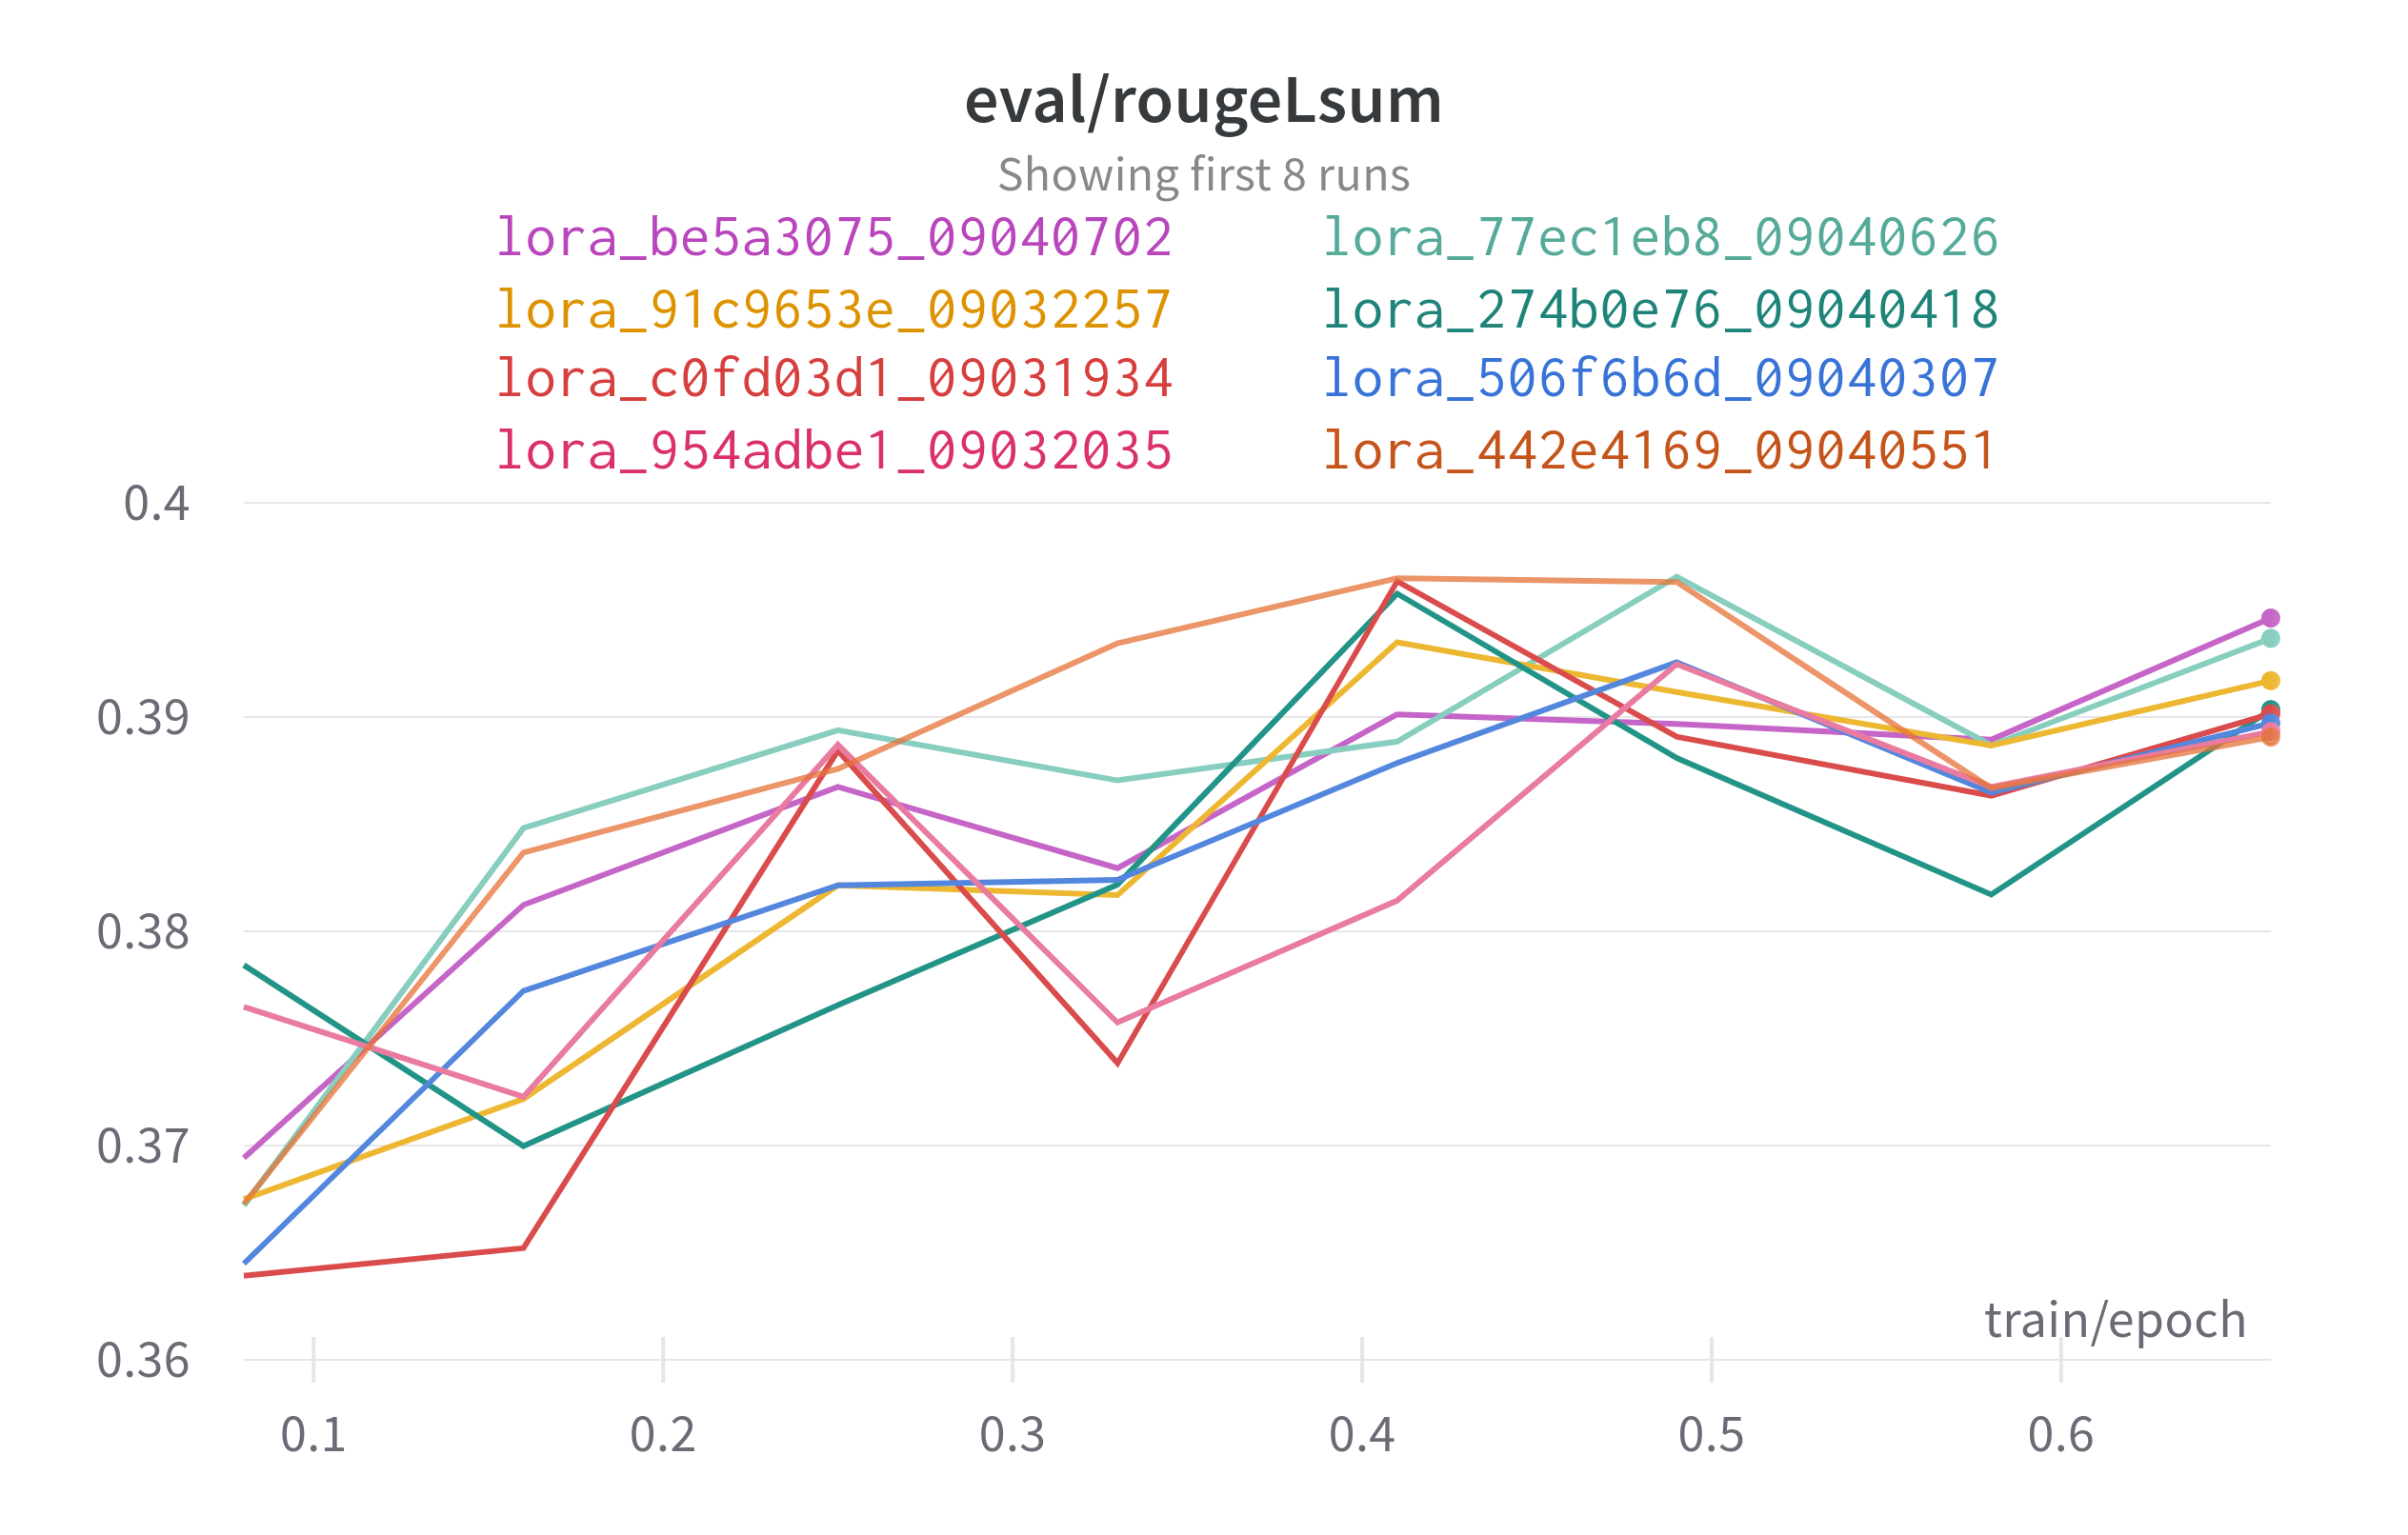